In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchts.nn.loss import mis_loss
from torchts.nn.model import TimeSeriesModel

# Generate dataset

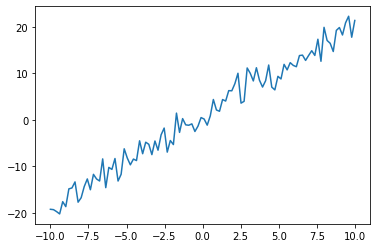

In [2]:
# generate linear time series data with some noise
x = np.linspace(-10,10,100).reshape(-1,1).astype(np.float32)
y = 2*x+1 + np.random.normal(0, 2, x.shape).reshape(-1,1).astype(np.float32)
plt.plot(x.flatten(), y.flatten())
plt.show()

# Define LSTM model

In [3]:
class LSTM(TimeSeriesModel):
    def __init__(self, input_size, output_size, optimizer, hidden_size=8, batch_size=10, **kwargs):
        super(LSTM, self).__init__(optimizer, **kwargs)
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.lstm = torch.nn.LSTMCell(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        # initialize the hidden state and the cell state to zeros
        return (
            torch.zeros(self.batch_size, self.hidden_size),
            torch.zeros(self.batch_size, self.hidden_size),
        )

    def forward(self, x, y=None, batches_seen=None):
        hc = self.init_hidden()
        hidden, _ = self.lstm(x, hc)
        out = self.linear(hidden)
        return out

In [4]:
inputDim = 1       
outputDim = 1 
hidden_size = 16
optimizer_args = {"lr": 0.01}
interval = 0.95
batch_size = 10

model = LSTM(
    inputDim,
    2 * outputDim,
    torch.optim.Adam,
    hidden_size=hidden_size,
    criterion=mis_loss,
    criterion_args={"interval": interval},
    optimizer_args=optimizer_args,
)

# Train model to predict confidence interval

In [5]:
# train model
model.fit(
    torch.from_numpy(x),
    torch.from_numpy(y),
    max_epochs=100,
    batch_size=batch_size,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 1.2 K 
1 | linear | Linear   | 34    
------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 156.58it/s, loss=7.47, v_num=5, train_loss_step=7.790, train_loss_epoch=7.400]


In [6]:
# inference
y_preds = None

for x_batch in torch.split(torch.from_numpy(x), batch_size):
    pred = model.predict(x_batch).detach().numpy()

    if y_preds is None:
        y_preds = pred
    else:
        y_preds = np.vstack([y_preds, pred])

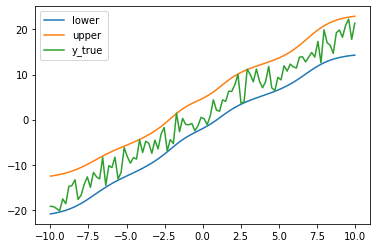

In [7]:
plt.plot(x.flatten(), y_preds, label=['lower', 'upper'])
plt.plot(x.flatten(), y.flatten(), label="y_true")
plt.legend()
plt.show()